In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from typing import Any

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
# from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassConfusionMatrix

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
torch.__version__

'2.5.1'

In [5]:
pl.__version__

'2.5.1.post0'

#### Calculating the mean and std dev of the images in the selected dataset

In [6]:
# Setting dataset path
path = "E:\\mini_ImageNet\\archive\\"

In [7]:
#Hardcoding the mean and std values; these were calculated in nb 1
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

print("Mean:", mean)
print("Std:", std)

Mean: [0.4764, 0.4491, 0.4001]
Std: [0.2264, 0.2224, 0.2212]


### Model Building

In [8]:
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                       saturation=0.2)], p=0.5), # jitters by +/- given value
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

In [9]:
#Getting class names from the folder names of images
class_names=sorted(os.listdir(path))
class_names = ['_'.join(c.split('_')[:-1]) for c in class_names]

In [10]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size:int=32, num_workers:int=4, transform=transform):
        super().__init__()
        # self.root_dir = "/kaggle/input/miniimagenet"
        self.root_dir = path
        self.transform = transform
        self.batch_size = batch_size
        self.num_w = num_workers

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid
        
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])
        
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
        

In [14]:
class ConvolutionalNetwork(pl.LightningModule):
    
    def __init__(self, class_labels:list=class_names, numChannels:int=3):
        super(ConvolutionalNetwork, self).__init__()
        self.confmat = MulticlassConfusionMatrix(num_classes=len(class_labels))
        
        #Initializing variable to collect grad norms 
        self._grad_norms = {}
        
        self.test_preds = []
        self.test_targets = []
        
        self.class_labels = class_labels
        
        ##Initializing channel sizes for different layers
        
        self.conv1_out_channels = 64
        self.conv2_out_channels = 96
        self.conv3_out_channels = 128
        self.conv4_out_channels = 128
        
        self.fc1_out_features = 512
        self.fc2_out_features = 256
        self.fc3_out_features = len(self.class_labels)
        
        #Initializing lists to store train and val accuracies and losses
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []


        #First conv layer block
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=self.conv1_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.conv1_out_channels)
        self.act1 = nn.LeakyReLU(0.05)          #also try leaky relu
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Second conv layer block
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_channels, out_channels=self.conv2_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.conv2_out_channels)
        self.act2 = nn.LeakyReLU(0.05)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Third conv layer block
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_channels, out_channels=self.conv3_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.conv3_out_channels)
        self.act3 = nn.LeakyReLU(0.05)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        #Fourth conv layer block
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_channels, out_channels=self.conv4_out_channels, 
                               kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self.conv4_out_channels)
        self.act4 = nn.LeakyReLU(0.05)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Flatten
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.LazyLinear(self.fc1_out_features)    #try bias=True ?
        self.dropout1 = nn.Dropout(0.291)
        self.act_fc1 = nn.LeakyReLU(0.05)
        
        self.fc2 = nn.Linear(in_features=self.fc1_out_features, out_features=self.fc2_out_features)
        self.dropout2 = nn.Dropout(0.334)
        self.act_fc2 = nn.LeakyReLU(0.05)
        
        self.fc3 = nn.Linear(in_features=self.fc2_out_features, out_features=self.fc3_out_features)
        self.output_activation  = nn.LogSoftmax(dim=1)
        
    # convolution output size formula: https://i.sstatic.net/vD1u3.png
    
    
    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        x = self.dropout1(self.act_fc1(self.fc1(x)))
        x = self.dropout2(self.act_fc2(self.fc2(x)))
        x = self.output_activation(self.fc3(x))
        
        return x
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.00046)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True),
            'monitor': 'val_loss'
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def setup(self, stage: str):
        self.confmat.to(self.device)

    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = (pred.squeeze() == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        accuracy = (preds == y).float().mean()

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy, on_step=False, on_epoch=True, prog_bar=True)
        
        
        # Store predictions and targets
        self.test_preds.append(preds.detach().cpu())
        self.test_targets.append(y.detach().cpu())

        return loss
    

    def on_train_epoch_end(self):
        train_acc = self.trainer.callback_metrics.get("train_acc")
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_acc is not None:
            self.training_accuracies.append(train_acc.item())
        if train_loss is not None:
            self.training_losses.append(train_loss.item())
        print(f"\nTrain - After Epoch {self.current_epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}")
        for param_group in self.trainer.optimizers[0].param_groups:
            print(f"Learning rate after epoch {self.current_epoch}: {param_group['lr']}")
        
        #Calculating average grad norms
        vanished_count = 0
        exploded_count = 0
        total_layers = len(self._grad_norms)

        for name, norms in self._grad_norms.items():
            avg_norm = sum(norms) / len(norms)

            # Log to TensorBoard
            self.logger.experiment.add_scalar(f"grad_norm_epoch_avg/{name}", avg_norm, self.current_epoch)

            # Stats
            if avg_norm < 1e-6:
                vanished_count += 1
            elif avg_norm > 100:
                exploded_count += 1

        # Log total stats
        self.log("grad_stats/total_layers", total_layers, on_epoch=True)
        self.log("grad_stats/vanished", vanished_count, on_epoch=True)
        self.log("grad_stats/exploded", exploded_count, on_epoch=True)

        print(f"[Epoch {self.current_epoch}] Grad Norms — Total: {total_layers}, Vanished: {vanished_count}, Exploded: {exploded_count}")

        # Reset buffer
        self._grad_norms.clear()
    

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            self.validation_accuracies.append(val_acc.item())
        if val_loss is not None:
            self.validation_losses.append(val_loss.item())
        print(f"\nVal - After Epoch {self.current_epoch}: loss={val_loss:.3f}, acc={val_acc:.3f}")
    
    
    def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        for name, param in self.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                if name not in self._grad_norms:
                    self._grad_norms[name] = []
                self._grad_norms[name].append(norm)
    
    def on_test_epoch_end(self):
        
        all_preds = torch.cat(self.test_preds)
        all_targets = torch.cat(self.test_targets)

        device = self.device  # or all_preds.device, just be consistent
        self.confmat = self.confmat.to(device)
        all_preds = all_preds.to(device)
        all_targets = all_targets.to(device)

        # Update and compute confusion matrix
        self.confmat.update(all_preds, all_targets)
        conf_matrix = self.confmat.compute()
        
        # Plot
        class_names_ = self.class_labels
        num_classes = len(class_names_)
        fig_size = max(10, num_classes * 0.3)

        plt.figure(figsize=(fig_size, fig_size))
        sns.heatmap(conf_matrix.cpu().numpy(),
                    annot=False,
                    cmap='Blues',
                    fmt='d',
                    xticklabels=class_names_,
                    yticklabels=class_names_)
        
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90, fontsize=max(6, 100 / num_classes))
        plt.yticks(rotation=0, fontsize=max(6, 100 / num_classes))
        plt.tight_layout()
        plt.show()

        # Reset confusion matrix and buffers
        self.confmat.reset()
        self.test_preds.clear()
        self.test_targets.clear()
        self.final_confusion_matrix = conf_matrix.clone().detach().cpu()


In [15]:
# model_path = "D:\\Code\\Mini Imagenet Classification\\checkpoints\\2025-06-11_21-01-14\\epochepoch=99-val_lossval_loss=1.69.ckpt"
model_path = "D:\\Code\\Mini Imagenet Classification\\checkpoints\\2025-06-15_21-06-29\\epochepoch=90-val_lossval_loss=1.67.ckpt"
model_path

'D:\\Code\\Mini Imagenet Classification\\checkpoints\\2025-06-15_21-06-29\\epochepoch=90-val_lossval_loss=1.67.ckpt'

In [16]:
model = ConvolutionalNetwork.load_from_checkpoint(model_path)
model.eval()

ConvolutionalNetwork(
  (confmat): MulticlassConfusionMatrix()
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.05)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.05)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): LeakyReLU(negative_slope=0.05)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1

In [17]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Total trainable parameters: {trainable_params}")
print(f"Total non-trainable parameters: {non_trainable_params}")
print(f"Total parameters (trainable + non-trainable): {trainable_params + non_trainable_params}")

Total trainable parameters: 13306066
Total non-trainable parameters: 0
Total parameters (trainable + non-trainable): 13306066


In [18]:
pl.seed_everything(42, workers=True)  

datamodule = DataModule(batch_size=64, num_workers=8)
datamodule.setup(stage='test')

Seed set to 42


In [19]:
trainer = pl.Trainer(
    accelerator='auto', # Use 'gpu' if you know it's available, 'cpu' otherwise
    devices=1,          # Number of GPUs/CPUs to use
    logger=False,       # Don't log to TensorBoard during testing if not needed
    enable_checkpointing=False # Don't save checkpoints during testing
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.53it/s]

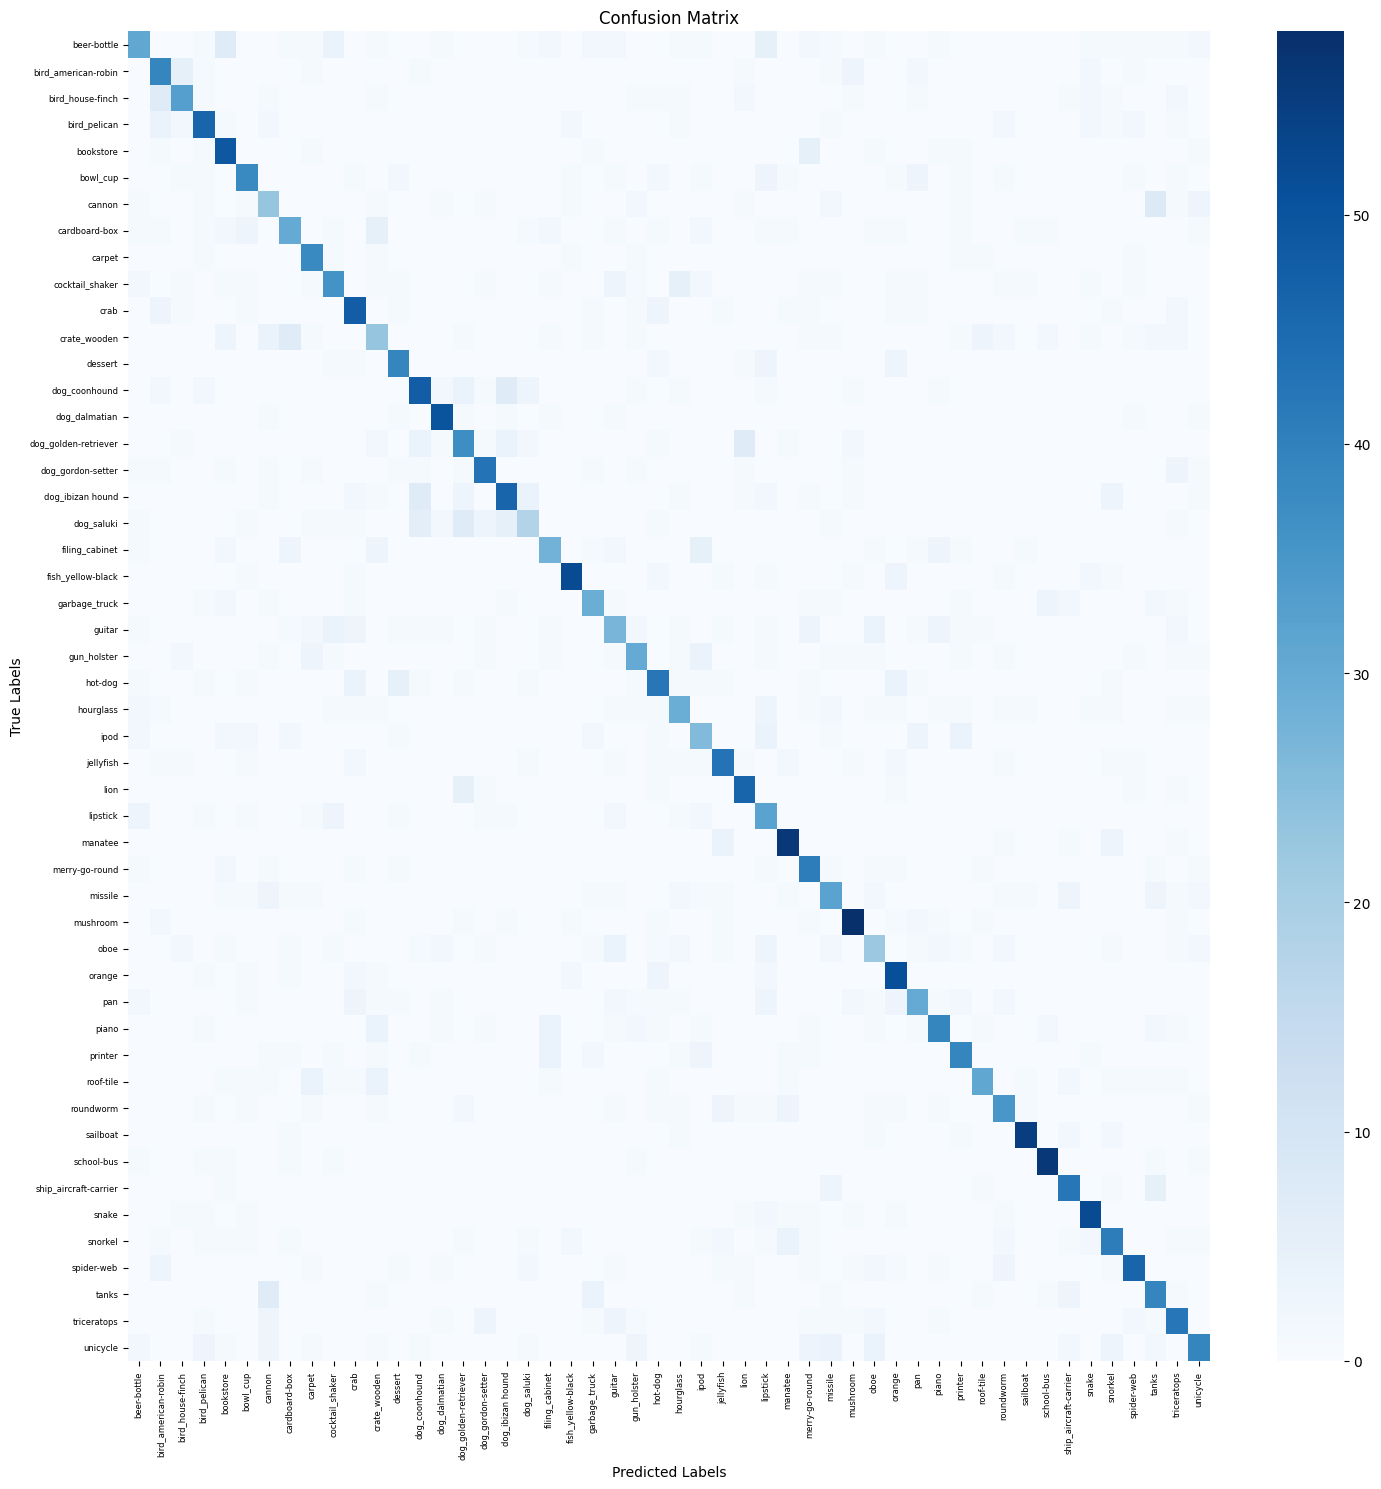

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 47/47 [00:11<00:00,  4.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6483333110809326
        test_loss            1.249084711074829
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [20]:
test_results = trainer.test(model, datamodule=datamodule)

In [21]:
print("\nTest Results:")
print(test_results)


Test Results:
[{'test_loss': 1.249084711074829, 'test_acc': 0.6483333110809326}]


### Test accuracy: 64.83%

In [22]:
if test_results:
    print(f"Final Test Loss: {test_results[0].get('test_loss'):.4f}")
    print(f"Final Test Accuracy: {test_results[0].get('test_acc')*100:.4f}")

Final Test Loss: 1.2491
Final Test Accuracy: 64.8333


In [23]:
conf_matrix = model.final_confusion_matrix
print(conf_matrix)

tensor([[31,  0,  0,  ...,  1,  1,  2],
        [ 0, 39,  5,  ...,  0,  0,  0],
        [ 0,  7, 33,  ...,  0,  2,  0],
        ...,
        [ 0,  0,  0,  ..., 39,  1,  0],
        [ 0,  0,  0,  ...,  1, 42,  0],
        [ 2,  0,  0,  ...,  2,  0, 39]])


In [24]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [25]:
df_conf_matrix = pd.DataFrame(conf_matrix)
df_conf_matrix['class_names'] = class_names
df_conf_matrix = df_conf_matrix.set_index('class_names')

for idx, col in enumerate(df_conf_matrix.columns):
    df_conf_matrix.rename(columns={col:class_names[idx]}, inplace=True)

In [26]:
df_conf_matrix

beer-bottle  bird_american-robin  bird_house-finch  \
class_names                                                                 
beer-bottle                     31                    0                 0   
bird_american-robin              0                   39                 5   
bird_house-finch                 0                    7                33   
bird_pelican                     0                    4                 2   
bookstore                        0                    1                 0   
bowl_cup                         0                    0                 1   
cannon                           1                    0                 0   
cardboard-box                    1                    1                 0   
carpet                           0                    0                 0   
cocktail_shaker                  2                    0                 1   
crab                             0                    3                 1   
crate_wooden                     0                    0                 0   
dessert                          0                    0                 0   
dog_coonhound                    0                    2                 0   
dog_dalmatian                    0                    0                 0   
dog_golden-retriever             0                    0                 1   
dog_gordon-setter                1                    1                 0   
dog_ibizan hound                 0                    0                 0   
dog_saluki                       1                    0                 0   
filing_cabinet                   1                    0                 0   
fish_yellow-black                0                    0                 0   
garbage_truck                    0                    0                 0   
guitar                           1                    0                 0   
gun_holster                      0                    0                 2   
hot-dog                          1                    0                 0   
hourglass                        2                    1                 0   
ipod                             2                    0                 0   
jellyfish                        0                    1                 1   
lion                             0                    0                 0   
lipstick                         3                    0                 0   
manatee                          0                    0                 0   
merry-go-round                   1                    0                 0   
missile                          0                    0                 0   
mushroom                         0                    2                 0   
oboe                             0                    0                 2   
orange                           0                    0                 0   
pan                              2                    0                 0   
piano                            0                    0                 0   
printer                          0                    0                 0   
roof-tile                        0                    0                 0   
roundworm                        0                    0                 0   
sailboat                         0                    0                 0   
school-bus                       1                    0                 0   
ship_aircraft-carrier            0                    0                 0   
snake                            0                    0                 1   
snorkel                          0                    1                 0   
spider-web                       0                    3                 0   
tanks                            0                    0                 0   
triceratops                      0                    0                 0   
unicycle                         2                    0                 0   

                  

In [27]:
dog_breeds = list(df_conf_matrix[df_conf_matrix.index.str.startswith('dog')].index)
df_conf_matrix[dog_breeds][df_conf_matrix.index.isin(dog_breeds)]

dog_coonhound  dog_dalmatian  dog_golden-retriever  \
class_names                                                                
dog_coonhound                    48              2                     4   
dog_dalmatian                     0             50                     1   
dog_golden-retriever              4              1                    37   
dog_gordon-setter                 1              0                     1   
dog_ibizan hound                  7              0                     3   
dog_saluki                        6              2                     7   

                      dog_gordon-setter  dog_ibizan hound  dog_saluki  
class_names                                                            
dog_coonhound                         1                 7           3  
dog_dalmatian                         0                 1           0  
dog_golden-retriever                  1                 4           2  
dog_gordon-setter                    43                 0           0  
dog_ibizan hound                      0                46           4  
dog_saluki                            3                 5          18

We can see that the dog breeds are often misclassified as other dog breeds. Similarly, tanks and cannons are misclassified, as are cardboard boxes and filing cabinets. This is because the dataset has many classes that are closely related, and a few classes that are distinct from the rest.

In [28]:
def visualize_feature_map(model: nn.Module, layer_to_inspect: nn.Module, 
                          input_image_tensor: torch.Tensor, input_image_label: int,
                          class_names: list, unnormalize_transform: transforms.Normalize):
    """
    Visualizes the feature map of a specified convolutional layer.

    Args:
        model (nn.Module): The entire model (e.g., your LightningModule.model).
        layer_to_inspect (nn.Module): The specific layer whose output you want to visualize.
                                      For ResNet18's first conv layer, this is model.conv1.
        input_image_tensor (torch.Tensor): A single input image tensor (C, H, W), preprocessed.
        input_image_label (int): The true label of the input image.
        class_names (list): List of class names for displaying the label.
        unnormalize_transform (transforms.Normalize): Transform to unnormalize the input image for display.
    """
    
    feature_map_output = None
    gradients = []
    
    def forward_hook(module, input, output):
        nonlocal feature_map_output # Allows modifying variable from outer scope
        feature_map_output = output.detach()
    
#     def backward_hook(module, grad_in, grad_out):
#         gradients.append(grad_out[0])
    
    # Register the hooks
    hook_handle_f = layer_to_inspect.register_forward_hook(forward_hook)
#     hook_handle_b = layer_to_inspect.register_backward_hook(backward_hook)

    # Set model to evaluation mode
    model.eval()

    # Ensure input image tensor has a batch dimension and is on the correct device
    input_image_batch = input_image_tensor.unsqueeze(0).to(model.device)

    # Pass the input image through the model to activate the hook
    with torch.no_grad():
        _ = model(input_image_batch)
    
    # Remove the hook
    hook_handle_f.remove()
    
    if feature_map_output is None:
        print("Error: Feature map not captured. Ensure the input passes through the specified layer.")
        return

    # Process and visualize the feature map
    feature_map = feature_map_output.squeeze(0).cpu().numpy() # Remove batch dim
    
            
    num_filters = feature_map.shape[0]
         
    rows = int(np.ceil(np.sqrt(num_filters)))
    cols = int(np.floor(np.sqrt(num_filters)))

    if rows * cols < num_filters:
        cols += 1

    plt.figure(figsize=(cols * 3, rows * 3))
        
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        single_feature_map = feature_map[i]
        # Normalize each feature map channel for display
        single_feature_map = (single_feature_map - single_feature_map.min()) / (single_feature_map.max() - single_feature_map.min() + 1e-8)
        plt.imshow(single_feature_map, cmap='viridis')
        plt.title(f'Feature map output {i+1}')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from {layer_to_inspect.__class__.__name__}", fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout()
    plt.show()
    # Display the original image
    original_img_display = unnormalize_transform(input_image_tensor.cpu()).permute(1, 2, 0).numpy()
    original_img_display = np.clip(original_img_display, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(original_img_display)
    plt.title(f"Original Input Image (True Label: {class_names[input_image_label]})")
    plt.axis('off')
    plt.show()


In [29]:
# data_transforms = {'unnormalize': transforms.Normalize(
#                                 mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#                                 std=[1/0.229, 1/0.224, 1/0.225]
#                             )}

data_transforms = {'unnormalize': transforms.Normalize(
                                                mean = [0.4764, 0.4491, 0.4001],
                                                std = [0.2264, 0.2224, 0.2212])}

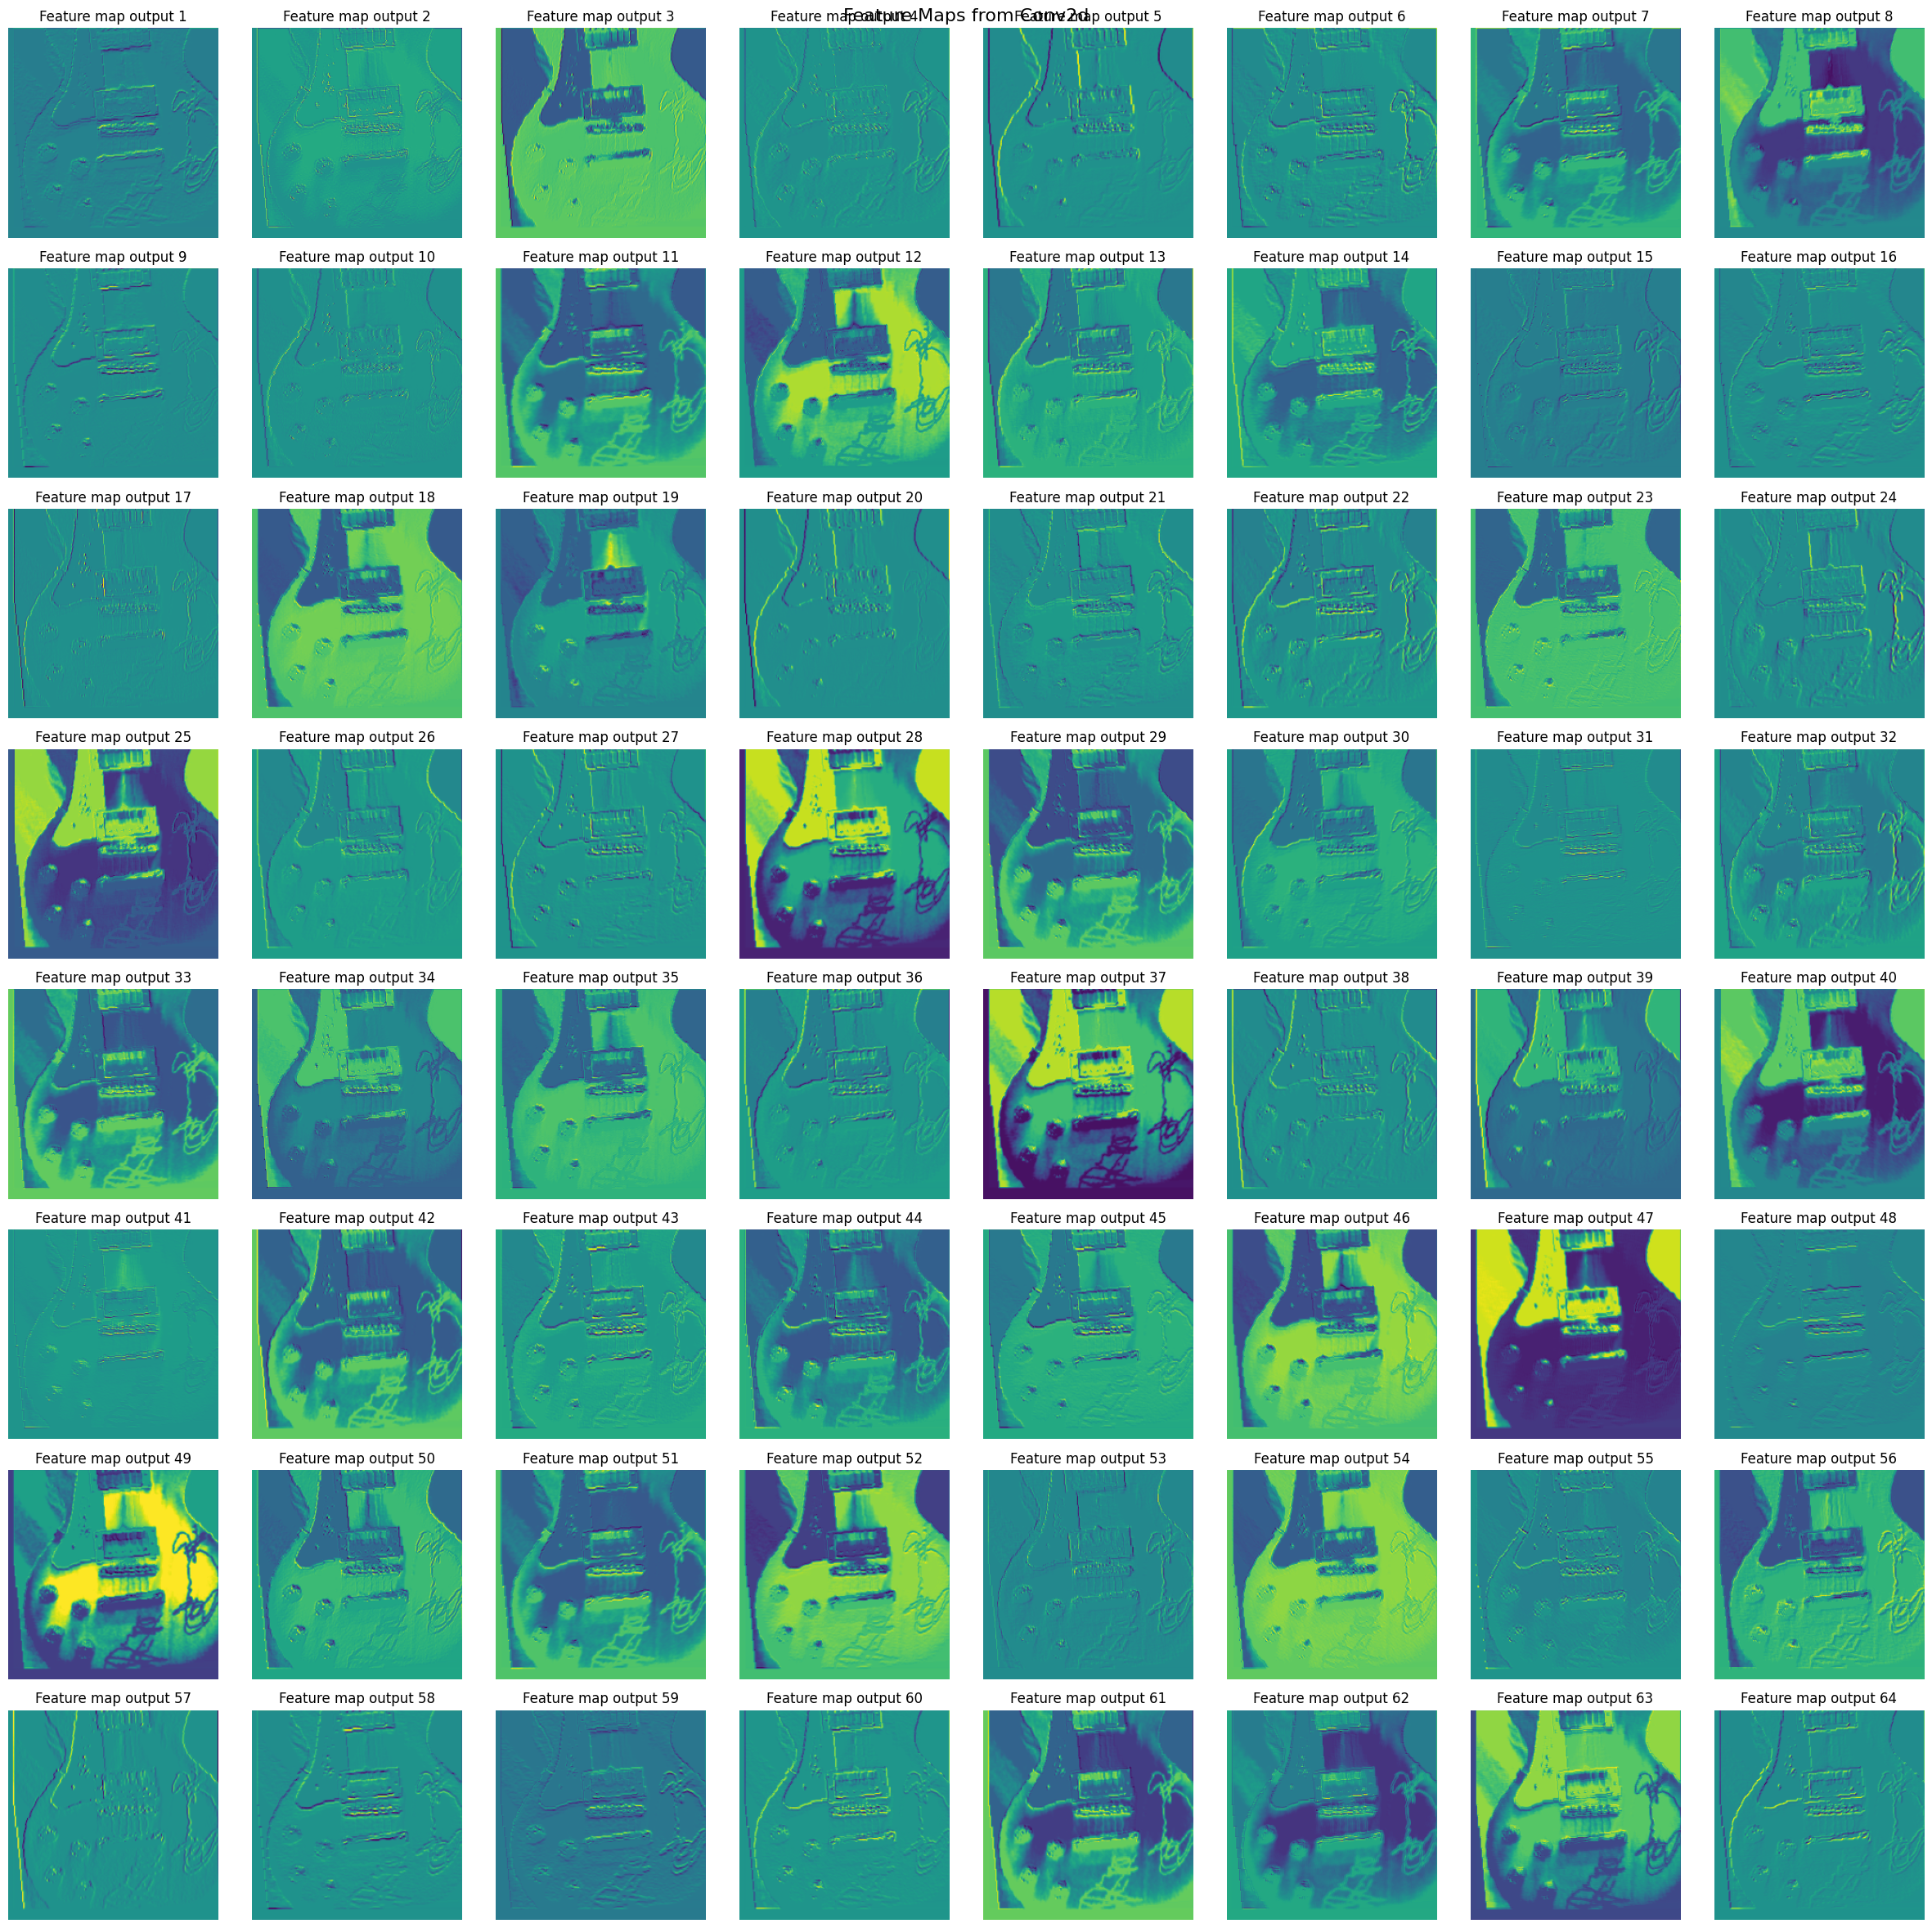

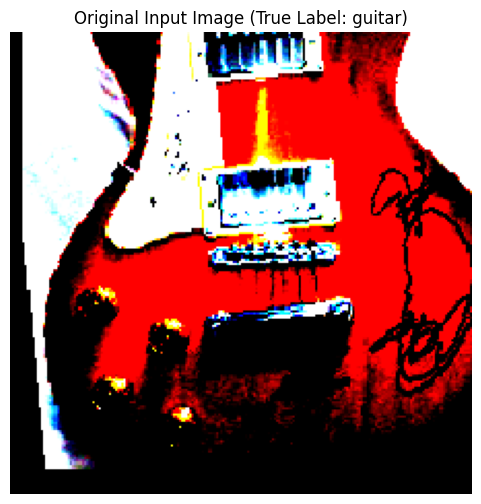

In [30]:
# Get a sample from the validation dataset
sample_index = 8
sample_image_tensor, input_image_label = datamodule.val_dataset[sample_index]

visualize_feature_map(
    model=model, # Pass the underlying torch.nn.Module, not the LightningModule
    layer_to_inspect=model.conv1, # The specific layer
    input_image_tensor=sample_image_tensor,
    input_image_label=input_image_label,
    class_names=class_names,
    unnormalize_transform=data_transforms['unnormalize'],
)

Feature maps in the first convolutional layer appear to be edge detectors in different orientations. They are also activated by certain color gradients.

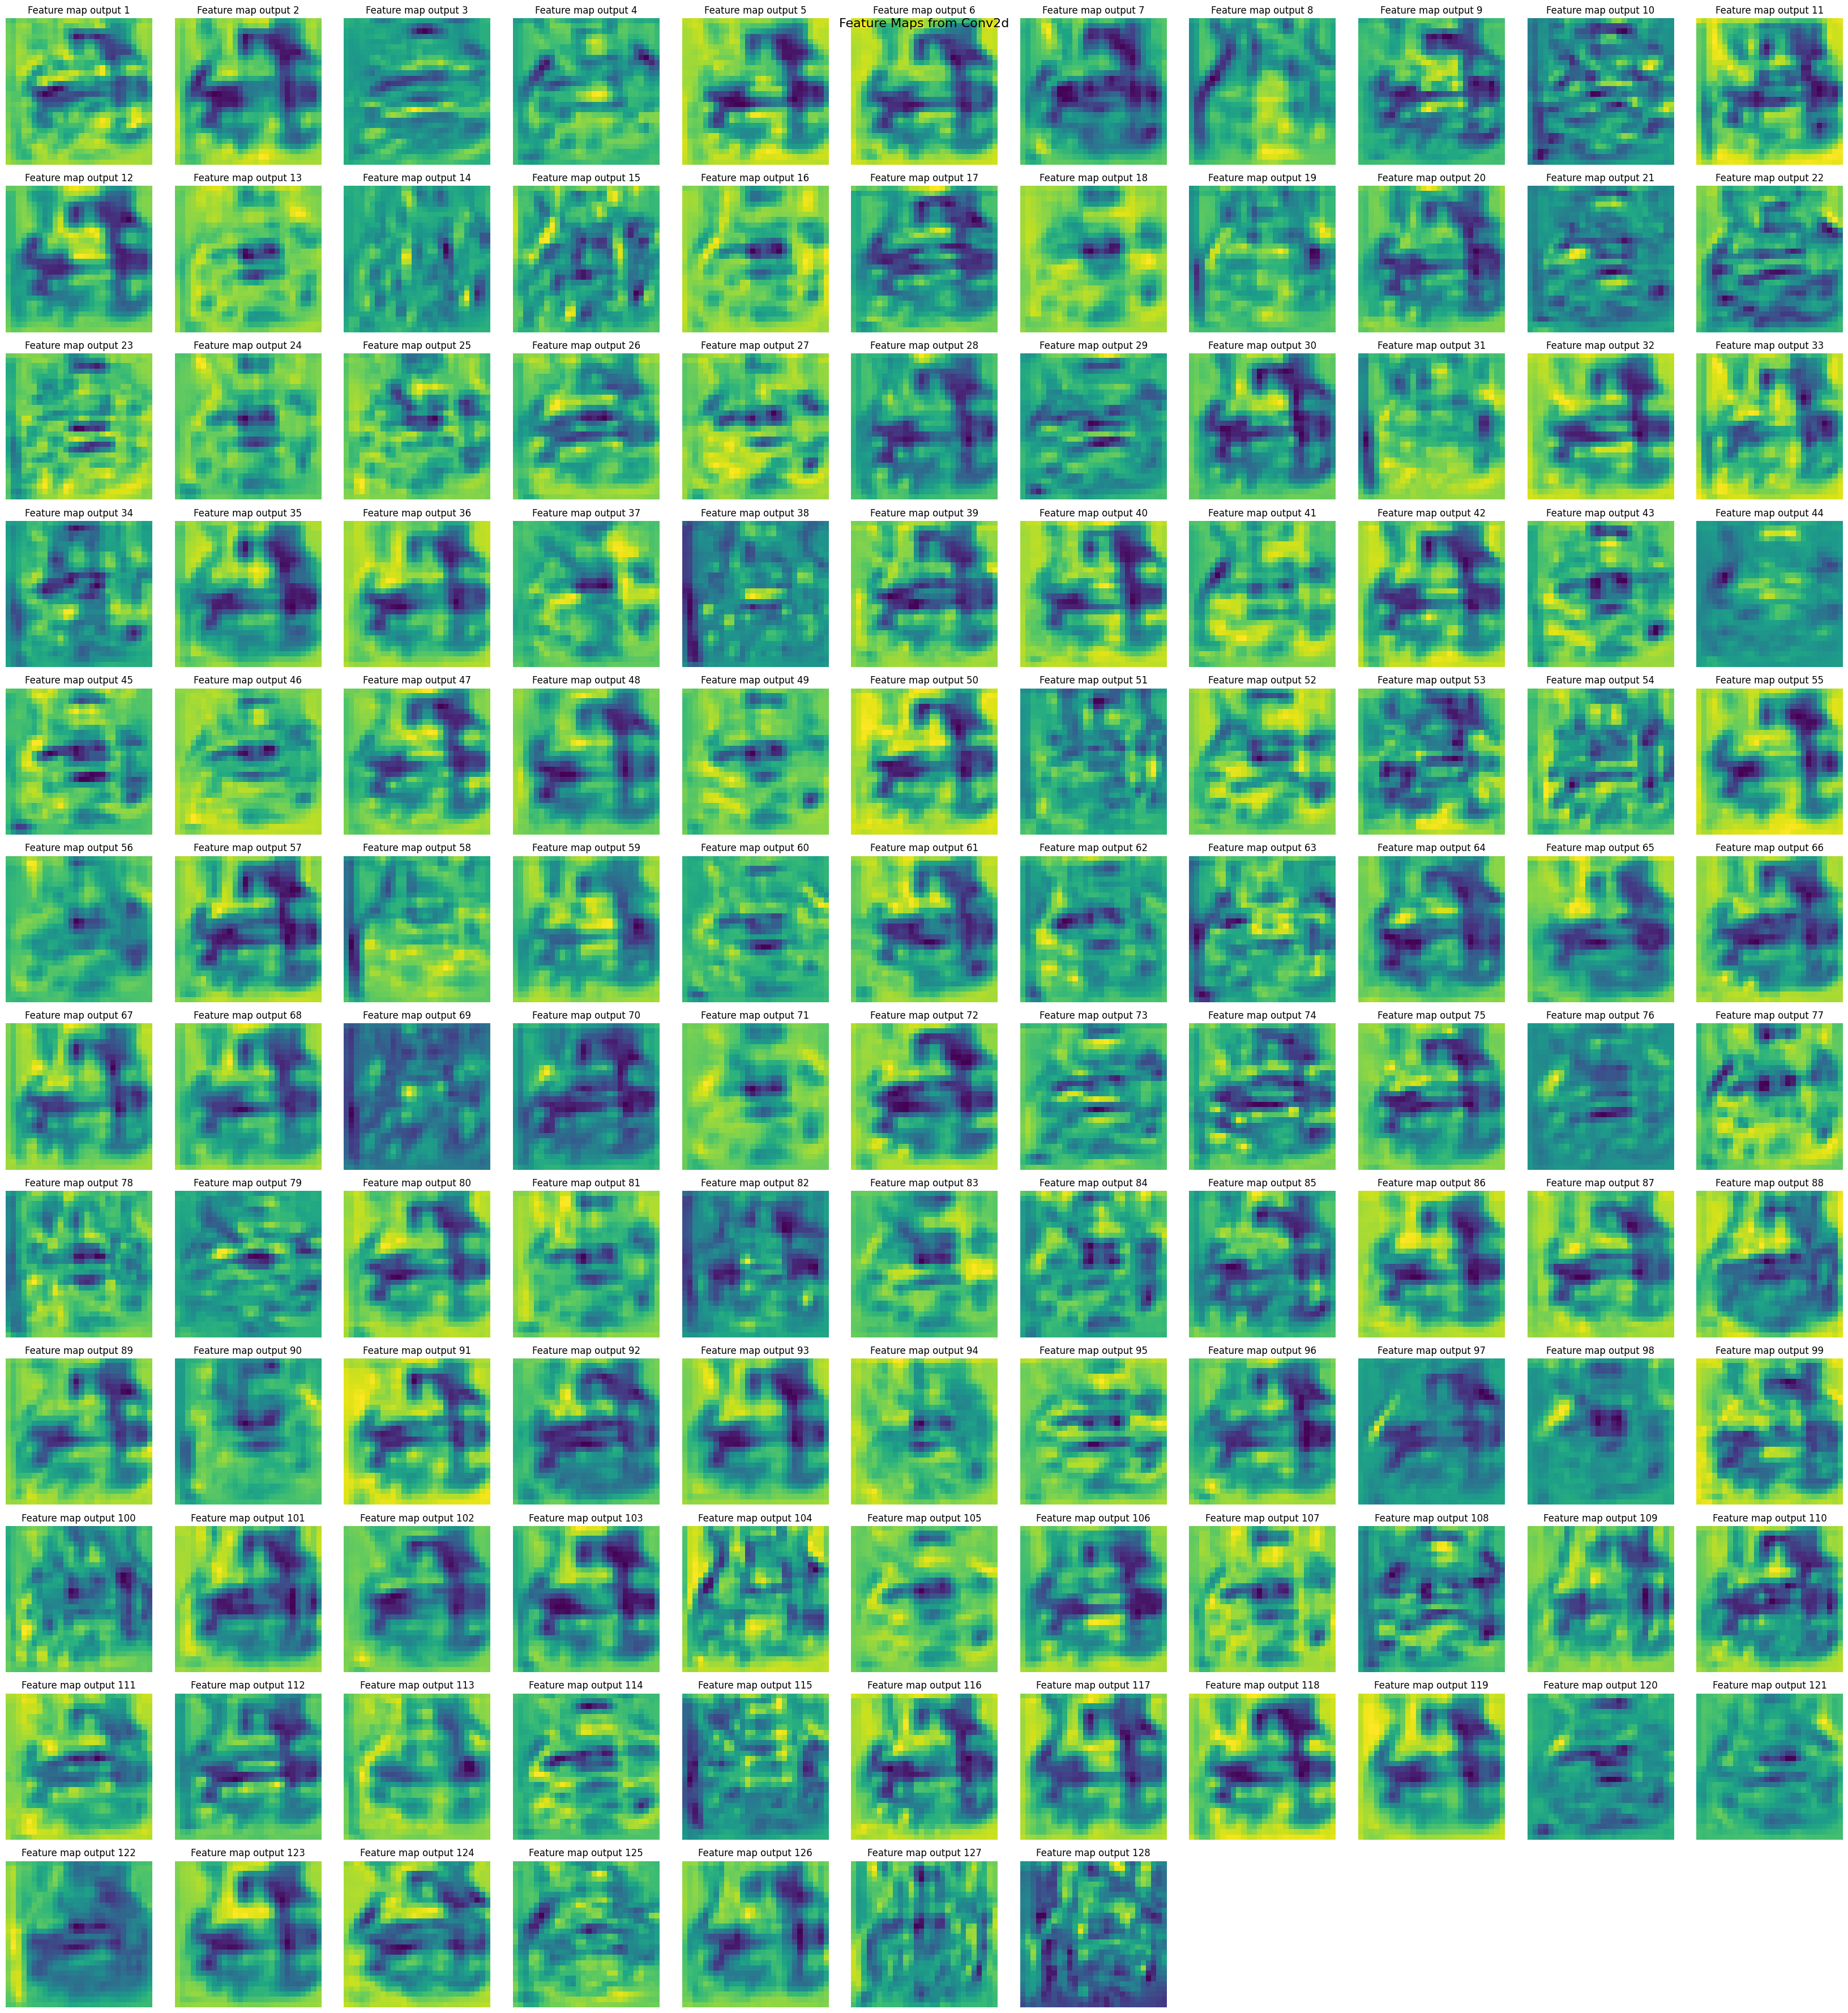

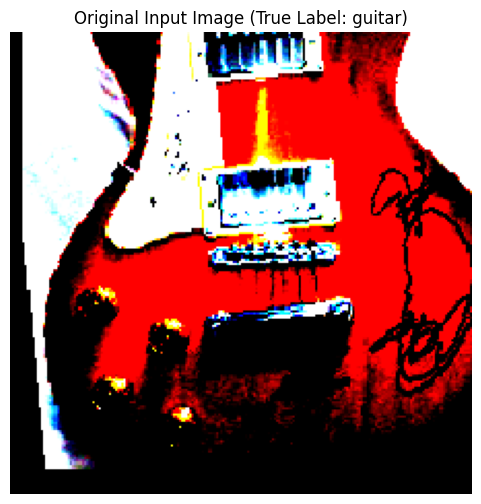

In [31]:
visualize_feature_map(
    model=model, # Pass the underlying torch.nn.Module, not the LightningModule
    layer_to_inspect=model.conv4, # The specific layer
    input_image_tensor=sample_image_tensor,
    input_image_label=input_image_label,
    class_names=class_names,
    unnormalize_transform=data_transforms['unnormalize'],
)

The feature maps in the latter layers identify abstract features in the image.

Let's check which of the above feature maps was the most important in classifying this image.

In [32]:
# Hook the last conv layer
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# Register hooks on last conv layer
target_layer = model.conv4 
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


# Forward + backward pass
model.eval()
output = model(sample_image_tensor.unsqueeze(0).to(model.device))
class_score = output[0, input_image_label]
model.zero_grad()
class_score.backward()

# Get the gradients and activations
grads = gradients[0].detach()         # [batch, channels, h, w]
acts = activations[0].detach()        # [batch, channels, h, w]

# Compute averages of weights
weights = grads.mean(dim=(2, 3))      # global average pooling over H and W

most_important_idx = weights[0].argmax().item()
print("Most important feature map for classification: ",most_important_idx+1)

Most important feature map for classification:  38


C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Feature map 38 identifies the general shape, knobs, bridge, and pickups of a guitar.